<a href="https://colab.research.google.com/github/NikolValerie/PANDAS-real-estate/blob/main/Reviews_class_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch

import matplotlib.pyplot as plt

# импортируем трансформеры
import transformers
import warnings
warnings.filterwarnings('ignore')

In [25]:
file_path = 'kinopoisk.jsonl'

# Open the JSONL file and read its contents
with open(file_path, 'r') as file:
    # Initialize an empty list to store JSON objects
    json_data = []

    # Read each line in the JSONL file
    for line in file:
        # Parse the JSON object from the line and append it to the list
        json_data.append(json.loads(line))

# Create a Pandas DataFrame from the list of JSON objects
df = pd.DataFrame(json_data)

df

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24T00:00:00,Плакали наши денежки ©,Good,10,"\n""Блеф» — одна из моих самых любимых комедий...."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04T00:00:00,None,Good,0,\nАдриано Челентано продолжает радовать нас св...
2,top250,Блеф (1976),17137,Flashman,2007-03-04T00:00:00,None,Good,10,"\nНесомненно, это один из великих фильмов 80-х..."
3,top250,Блеф (1976),17135,Sergio Tishin,2009-08-17T00:00:00,""" Черное, красное, ерунда это все. Выигрывает ...",Good,0,\nЭта фраза на мой взгляд отражает сюжет несом...
4,top250,Блеф (1976),17151,Фюльгья,2009-08-20T00:00:00,"«Он хотел убежать? Да! Блеф, блеф…»",Neutral,7,"\n- как пела Земфира, скорее всего, по соверше..."
...,...,...,...,...,...,...,...,...,...
36586,bottom100,Цветок дьявола (2010),25123,bestiya163,2010-09-23T00:00:00,"Ой, ой, ой!",Bad,2,\n Ну с чего бы начать… Давненько я не пи...
36587,bottom100,Цветок дьявола (2010),25192,Молка,2010-10-02T00:00:00,Молчаливый мужик на коне…,Bad,1,"\n Можно начать с того, что уже постер к ..."
36588,bottom100,Цветок дьявола (2010),25080,jetry,2010-09-16T00:00:00,Это проявилось сегодня ночью.,Good,7,"\n Фильм производства России, поэтому мно..."
36589,bottom100,Цветок дьявола (2010),25088,Alkort,2010-09-16T00:00:00,«Finita la comedia»,Bad,0,\n 16 сентября на большие экраны вышел «м...


In [26]:
df.columns.to_list()

['part',
 'movie_name',
 'review_id',
 'author',
 'date',
 'title',
 'grade3',
 'grade10',
 'content']

In [36]:
df_red = df[['content', 'grade3']]

In [37]:
df_red['sen_enc'] = LabelEncoder().fit_transform(df_red['grade3'])

In [38]:
df_red.head()

,content,grade3,sen_enc
0,"\n""Блеф» — одна из моих самых любимых комедий....",Good,1
1,\nАдриано Челентано продолжает радовать нас св...,Good,1
2,"\nНесомненно, это один из великих фильмов 80-х...",Good,1
3,\nЭта фраза на мой взгляд отражает сюжет несом...,Good,1
4,"\n- как пела Земфира, скорее всего, по соверше...",Neutral,2


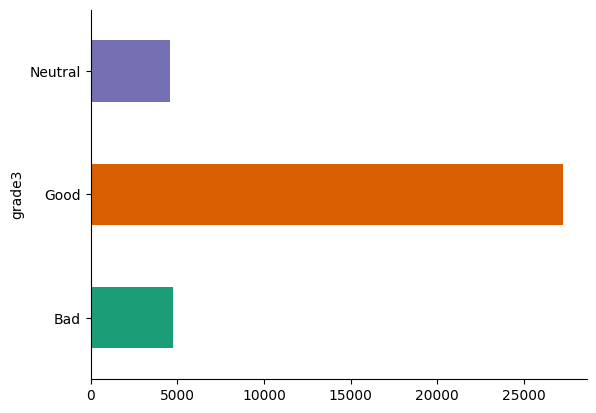

In [39]:
# @title grade3

from matplotlib import pyplot as plt
import seaborn as sns
df_red.groupby('grade3').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [41]:
# Filter out the extra data from the "Good" class to balance the dataset
good_count = df_red['grade3'].value_counts()['Good']
bad_count = df_red['grade3'].value_counts()['Bad']
neutral_count = df_red['grade3'].value_counts()['Neutral']

df_balanced = pd.concat([
    df_red[df_red['grade3'] == 'Good'].sample(min(good_count, bad_count, neutral_count), random_state=42),
    df_red[df_red['grade3'] == 'Bad'].sample(min(good_count, bad_count, neutral_count), random_state=42),
    df_red[df_red['grade3'] == 'Neutral'].sample(min(good_count, bad_count, neutral_count), random_state=42)
])

# Shuffle the dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the balanced distribution of grades in the new dataset
df_balanced['grade3'].value_counts()

grade3
Neutral    4576
Good       4576
Bad        4576
Name: count, dtype: int64

In [42]:
# rubert-tiny2:
from transformers import AutoTokenizer, AutoModel

## задаем саму модель
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

# токенайзер к ней (для некоторых моделей токенайзер будет отличаться, см.
## в документации к каждой модели конкретно)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [43]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

In [56]:
MAX_LEN = 300
tokenizer.encode(
    'Привет как дела',
    add_special_tokens=True,
    truncation=True,
    max_length=MAX_LEN,
    # padding='max_length'
    )

[2, 51343, 1150, 7843, 3]

In [57]:
tokenized = df_balanced['content'].apply((lambda x: tokenizer.encode(x,
                                                                      add_special_tokens=True,
                                                                      truncation=True,
                                                                      max_length=MAX_LEN)))

In [59]:
tokenized

0        [2, 73455, 304, 12206, 9141, 10871, 4182, 2474...
1        [2, 51023, 30929, 16, 20555, 33839, 8264, 1175...
2        [2, 73603, 38292, 10208, 3869, 2225, 64665, 76...
3        [2, 34571, 37861, 16, 1046, 745, 38110, 27100,...
4        [2, 11451, 5880, 343, 38756, 30058, 8281, 735,...
                               ...                        
13723    [2, 3760, 17717, 745, 6249, 13276, 30416, 3628...
13724    [2, 36492, 29454, 5557, 5880, 16, 343, 11677, ...
13725    [2, 18013, 105, 286, 4292, 1358, 4292, 117, 16...
13726    [2, 105, 37193, 117, 1, 5880, 4858, 16, 30310,...
13727    [2, 76533, 75810, 5584, 53490, 1172, 626, 8604...
Name: content, Length: 13728, dtype: object

In [60]:
for i in tokenized.values[:10]:
    print(len(i), end=' ')

213 199 265 300 227 300 300 300 300 260 

In [63]:
padded = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenized.values])

In [64]:
for i in padded[:10]:
    print(len(i), end=' ')

300 300 300 300 300 300 300 300 300 300 

In [66]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask[4]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
class BertInputs(torch.utils.data.Dataset):
    def __init__(self, tokenized_inputs, attention_masks):
        super().__init__()
        self.tokenized_inputs = tokenized_inputs
        self.attention_masks = attention_masks

    def __len__(self):
        return self.tokenized_inputs.shape[0]

    def __getitem__(self, idx):
        ids = self.tokenized_inputs[idx]
        ams = self.attention_masks[idx]

        return ids, ams

dataset = BertInputs(padded, attention_mask)

In [68]:
loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)
sample_ids, sample_ams = next(iter(loader))
print(sample_ids.shape, sample_ams.shape)

torch.Size([10, 300]) torch.Size([10, 300])


In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
model.to(device)

In [72]:
%%time
features = []
for inputs, attention_masks in loader:
# Получаем выход модели (нам оттуда нужно не все)
    with torch.inference_mode():
        last_hidden_states = model(inputs.cpu(), attention_mask=attention_masks.cpu())
        vectors = last_hidden_states[0][:,0,:].cpu().numpy()
    features.extend(vectors)
len(features)

CPU times: user 1h 27min 52s, sys: 32min 7s, total: 1h 59min 59s
Wall time: 2min 33s


13728

In [73]:
# Прогоним тестовый батч
with torch.inference_mode():
    last_hs = model(sample_ids.cpu(), attention_mask=sample_ams.cpu())
print(last_hs[0].shape)

torch.Size([10, 300, 312])


In [74]:
model_out_shape = last_hs[0].shape
print(model_out_shape)
print(f'{model_out_shape[0]} - число объектов,\n \
{model_out_shape[1]} - длина каждой последовательности, \n \
{model_out_shape[2]} - длина выходного вектора BERT для одного элемента последовательности')

torch.Size([10, 300, 312])
10 - число объектов,
 300 - длина каждой последовательности, 
 312 - длина выходного вектора BERT для одного элемента последовательности


In [79]:
X_train, X_val, y_train, y_val = train_test_split(features, df_balanced['sen_enc'])
print(f'Features shape: {len(X_train)}, Target shape: {len(y_train)}')

Features shape: 10296, Target shape: 10296


In [80]:
df_balanced['sen_enc'].value_counts()/len(features)*100

sen_enc
2    33.333333
1    33.333333
0    33.333333
Name: count, dtype: float64

In [ ]:
!pip install catboost

In [93]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.6 MB/s eta 0:00:00


In [94]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [95]:
# Define the models to be trained and the parameters to search for
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC()
}

param_grid = {
    "Logistic Regression": {'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 200, 300]},
    "Random Forest": {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
    "XGBoost": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Perform grid search for each model and select the best model
best_model = None
best_score = 0

for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], n_jobs=-1, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Evaluate the model on the validation data
predictions = best_model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f"Best Model: {best_model}")
print(f"Validation Accuracy: {accuracy}")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training SVM...
Best Model: LogisticRegression(C=0.1, max_iter=300)
Validation Accuracy: 0.6215034965034965


In [118]:
import random

# Select a random index
index = random.randint(0, len(df_balanced)-1)

# Get the random review content, predicted sentiment label, and actual sentiment label
review_content = df_balanced['content'][index]
actual_sentiment = df_balanced['grade3'][index]
predicted_sentiment = best_model.predict([features[index]])

print("Random Review Content:")
print(review_content)
print("\nActual Sentiment:", actual_sentiment)
print("Predicted Sentiment:", predicted_sentiment)

Random Review Content:

«Мистер Шерлок Холмс». Разве идет к этому разудалому боксеру и покорителю сердца красотки это имя? Не думаю. 

Все отмечают замечательные составляющие фильма: игра актеров заслуживает всяческих похвал, спецэффекты и декорации, музыка и диалоги. Но, где же мистер Холмс? Его нет. Его подменили. И вместе с ним нет притягательности, загадочности и наслаждения вкусом.

Так что в данном случчае Холмс — это просто хороший бренд. Как огромный ромбик «Липтона» над Домом художника.

Так что если вам не нужен старый добрый Холмс, то можете помотреть про нового. 

Хорошее добротное кино для семейного просмотра, но скорее всего единократного. Хотя… бренд может сработать и новый Холмс даст дорогу старому, который где-то спрятался.

7 из 10

Actual Sentiment: Neutral
Predicted Sentiment: [1]


In [147]:
model_path = 'best_model.pth'
torch.save(best_model, model_path)

print(f"Model saved at: {model_path}")

Model saved at: best_model.pth
